In [1]:
%cd ..

/home/alberto/PycharmProjects/incomplete_multiview_clustering


In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import adjusted_mutual_info_score
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
import seaborn as sns
from imvc.datasets import LoadDataset
from imvc.preprocessing import MultiViewTransformer, NormalizerNaN
from imvc.ampute import Amputer
from imvc.cluster import LFIMVC

In [3]:
Xs, y = LoadDataset.load_dataset(dataset_name="bbcsport", return_y=True)
y = y.squeeze()
Xs = [X.astype(float) for X in Xs]
n_clusters = y.nunique()

In [7]:
ps = np.arange(0., 1., 0.2)
n_times = 25
all_metrics = {}

In [8]:
key = "LFIMVC"
all_metrics[key] = {}
for p in ps:
    missing_percentage = int(p*100)
    all_metrics[key][missing_percentage] = {}
    for i in range(n_times):
        pipeline = make_pipeline(Amputer(p= p, mechanism="MCAR", random_state=i),
                                 MultiViewTransformer(NormalizerNaN().set_output(transform="pandas")),
                                 LFIMVC(n_clusters=int(n_clusters), random_state=i))
        clusters = pipeline.fit_predict(Xs)
        metric = adjusted_mutual_info_score(labels_true=y, labels_pred=clusters)
        all_metrics[key][missing_percentage][i] = metric

In [9]:
old_key = key
key = "Baseline (mean)"
all_metrics[key] = {}
all_metrics[key][0] = all_metrics[old_key][0]
for p in ps[1:]:
    missing_percentage = int(p*100)
    all_metrics[key][missing_percentage] = {}
    for i in range(n_times):
        pipeline = make_pipeline(Amputer(p= p, mechanism="MCAR", random_state=i),
                                 MultiViewTransformer(SimpleImputer().set_output(transform="pandas")),
                                 MultiViewTransformer(NormalizerNaN().set_output(transform="pandas")),
                                 LFIMVC(n_clusters=int(n_clusters), random_state=i))
        clusters = pipeline.fit_predict(Xs)
        metric = adjusted_mutual_info_score(labels_true=y, labels_pred=clusters)
        all_metrics[key][missing_percentage][i] = metric

In [28]:
flattened_data = [
    {
        'Method': outer_key,
        '% Incomplete samples': inner_key,
        **inner_dict
    }
    for outer_key, inner_dicts in all_metrics.items()
    for inner_key, inner_dict in inner_dicts.items()
]
df = pd.DataFrame(flattened_data)
df = df.melt(id_vars=['Method', '% Incomplete samples'], var_name='Iteration', value_name='Clustering performance (AMI)')
df = df.sort_values(["% Incomplete samples", "Method", "Iteration"], ascending=[True, False, True])

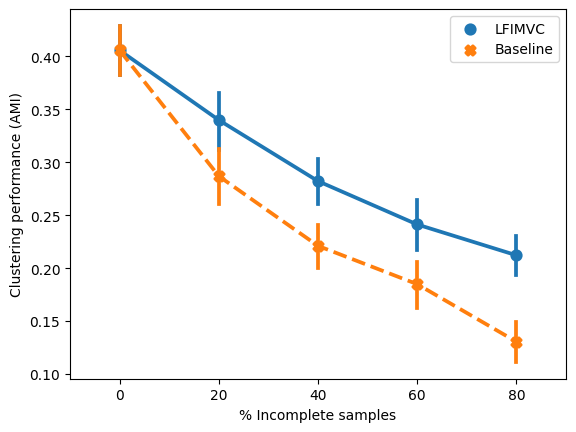

In [30]:
ax = sns.pointplot(data=df, x="% Incomplete samples", y="Clustering performance (AMI)", hue="Method", markers=["o", "X"], linestyles=["-", "--"], seed= 42)
ax = ax.get_legend().set_title(None)